In [1]:
import cv2 as cv
import numpy as np

In [2]:
base_path = f"data/Exp2_GuyGilad_logs_yolo"
input_bboxes_path = f"{base_path}/bboxes2.csv"

In [3]:
from evaluation.simulator import *
from evaluation.sim_controllers import *
from utils.path_utils import Files
from evaluation.config import *

experiment_config = ExperimentConfig.load_json(f"{base_path}/experiment_config.json")
# yolo_config = YoloConfig.load_json(f"{base_path}/yolo_config.json")

time_config = TimingConfig(
    imaging_time_ms=100,
    pred_time_ms=15,
    moving_time_ms=50,
    camera_size_mm=(4, 4),
    micro_size_mm=(0.22, 0.22),
    experiment_config=experiment_config,
)

log_config = LogConfig(
    root_folder="logs",
    save_mic_view=False,
    save_cam_view=False,
    save_err_view=False,
)

In [4]:
time_config.save_json("logs/time_config.json")

<class 'evaluation.config.TimingConfig'>


In [5]:
from pprint import pprint

pprint(time_config)

TimingConfig(px_per_mm=92,
             mm_per_px=0.010869565217391304,
             frames_per_sec=60,
             ms_per_frame=16.666666666666668,
             imaging_time_ms=100,
             imaging_frame_num=6,
             pred_time_ms=15,
             pred_frame_num=1,
             moving_time_ms=50,
             moving_frame_num=3,
             camera_size_mm=(4, 4),
             camera_size_px=(368, 368),
             micro_size_mm=(0.22, 0.22),
             micro_size_px=(20, 20))


In [6]:
weights = np.asanyarray([0.064, 0.0, 0.0, 0.001, 0.0, 0.001, 0.698, 0.0, 0.713])
               
sample_times = np.asanyarray(
    [
        0,
        5,
        9,
        -time_config.cycle_length + 0,
        -time_config.cycle_length + 5,
        -time_config.cycle_length + 9,
        -2 * time_config.cycle_length + 0,
        -2 * time_config.cycle_length + 5,
        -2 * time_config.cycle_length + 9,
    ]
)

In [7]:
from evaluation.sim_controllers.speed_controller import SpeedController
from evaluation.sim_controllers.polyfit_controller import PolyfitController
from evaluation.motor_controllers import *
from evaluation.sim_controllers.guys_controllers import MLPController
import torch

# sim_controller = YoloController(time_config, yolo_config)
# sim_controller = SpeedController(time_config, input_bboxes_path)
sim_controller = PolyfitController(time_config, input_bboxes_path, degree=1, weights=weights, sample_times=sample_times)
# sim_controller = OptimalController(time_config, input_bboxes_path)
# sim_controller = CsvController(time_config, input_bboxes_path)
model = torch.load("data/mlpRELU")
print(model)
# sim_controller = MLPController(time_config, input_bboxes_path, model)
log_controller = LoggingController(sim_controller, log_config)

motor = SineMotorController(time_config)
sim = Simulator(
    time_config,
    experiment_config,
    log_controller,
    reader=None,
    motor_controller=motor,
)

(64995, 4)
MLP(
  (sequence): Sequential(
    (0): Linear(in_features=20, out_features=120, bias=True)
    (1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_features=40, bias=True)
    (4): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=40, out_features=12, bias=True)
    (7): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=12, out_features=4, bias=True)
    (10): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=4, out_features=2, bias=True)
    (13): Identity()
    (14): Identity()
  )
)


In [8]:
sim.run(visualize=False, wait_key=False)

Simulation Progress:   0%|          | 0/7222 [00:00<?, ?cycle/s]

/home/yashlat/source/Bio-Proj/evaluation/sim_controllers/polyfit_controller.py:69: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(time, positions, deg=self.degree, w=weights)
/home/yashlat/source/Bio-Proj/evaluation/sim_controllers/polyfit_controller.py:69: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(time, positions, deg=self.degree, w=weights)


Correlation Coefficient: nan

Correlation Slope: 0.00
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


,wrm_speed,bbox_area_diff
count,7215.000000,7214.000000
mean,0.485160,0.016841
std,0.299533,0.039575
min,0.046290,0.000000
5%,0.226777,0.000000
10%,0.259538,0.000000
15%,0.285864,0.000000
20%,0.308694,0.000000
25%,0.333475,0.000000
30%,0.356854,0.000000


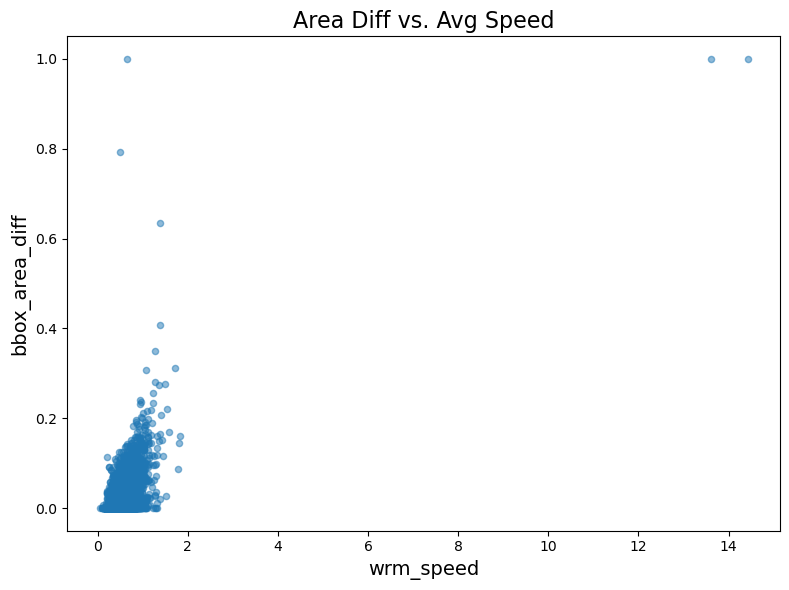

In [9]:
from evaluation.analysis import Plotter
from evaluation.config import *

pltr = Plotter(f"logs/bboxes.csv", time_config)
pltr.plot_area_vs_speed(min_speed=0.)

In [10]:
#data = pltr.print_statistics(n=10)

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_histogram(pltr, x_col:str, n:int=1, hue=None, condition=None, transform=None, **kwargs):
    data = pltr.data_prep_frames(n=n)
    
    if transform is not None:
        data = transform(data)
    if condition is not None:
            data = data[condition(data)]
    fig, ax = plt.subplots()
    sns.histplot(data=data, x=x_col, hue=hue,stat='density', **kwargs)

def plot_jointplot(pltr, x_col:str, y_col:str, n:int=1, kind:str='scatter', hue=None, condition=None, transform=None, **kwargs):
    data = pltr.data_prep_frames(n=n)
    
    if transform is not None:
        data = transform(data)
        
    if condition is not None:
            data = data[condition(data)]
    
    sns.jointplot(data=data, x=x_col, y=y_col, hue=hue, kind=kind, **kwargs)

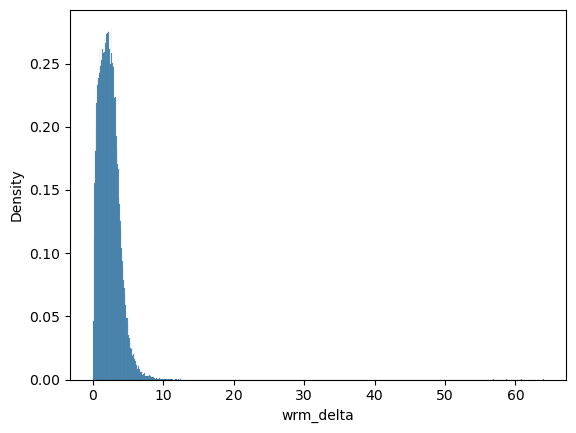

In [12]:
from functools import partial

def calc_speed(data: pd.DataFrame, n: int = 1) -> pd.DataFrame:
        """
        Calculate the worm speed and add it to the data.
        """
        frame_diff = data["frame"].diff(n).to_numpy()
        wrm_delta_x = data["wrm_center_x"].diff(n)
        wrm_delta_y = data["wrm_center_y"].diff(n)
        wrm_delta = np.sqrt(data["wrm_center_x"].diff(n) ** 2 + data["wrm_center_y"].diff(n) ** 2)
        data["wrm_delta"] = wrm_delta
        data["wrm_delta_x"] = wrm_delta_x
        data["wrm_delta_y"] = wrm_delta_y
        return data

plot_histogram(pltr, "wrm_delta", n=time_config.imaging_frame_num, transform=partial(calc_speed, n=time_config.imaging_frame_num))

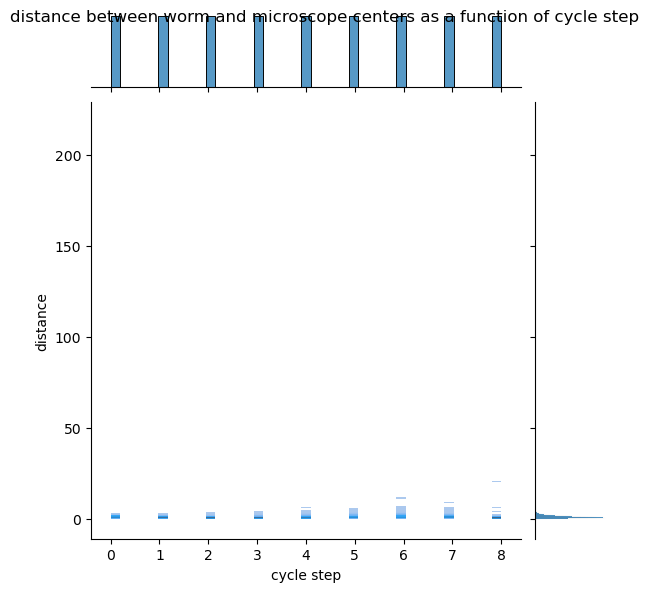

In [13]:
plot = pltr.plot_deviation(n=12)

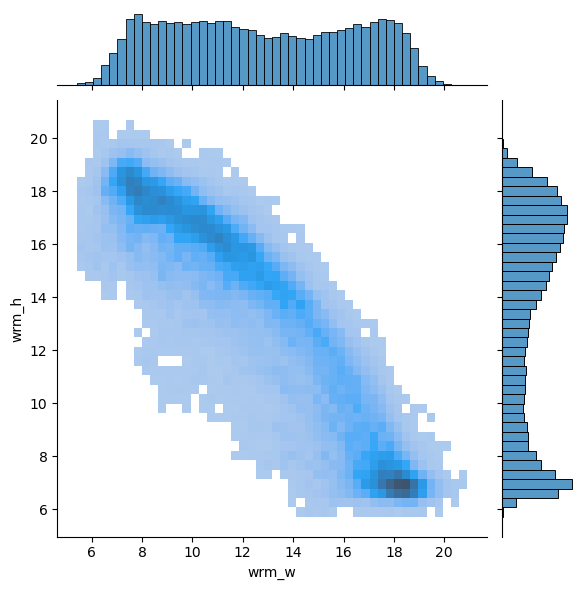

In [14]:
plot_jointplot(pltr, x_col="wrm_w", y_col="wrm_h", kind='hist')

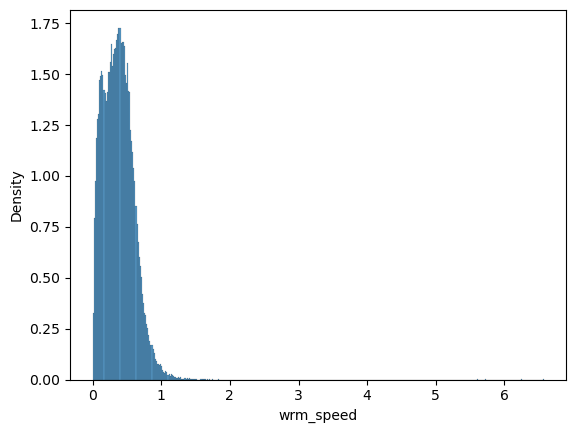

In [15]:
plot_histogram(pltr, "wrm_speed", 10)

In [16]:
def to_micro_meter(data):
    data[["wrm_speed2"]] = data[["wrm_speed"]] * time_config.mm_per_px * 1000 * time_config.frames_per_sec
    return data

In [17]:
0.87*600


522.0

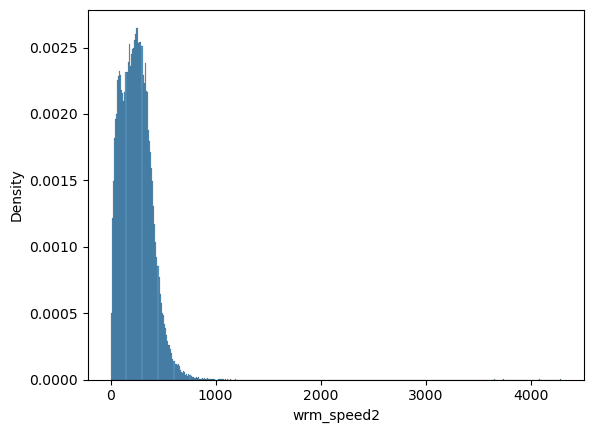

In [18]:
plot_histogram(pltr, "wrm_speed2", 10, transform=to_micro_meter)

In [19]:
cv.destroyAllWindows()
raise Exception("Finished")

Exception: Finished

In [ ]:
from evaluation.sim_controllers.polyfit_controller import WeightEvaluator

# input_offsets = np.asanyarray([0, 3, 6, 9])

input_offsets = np.asanyarray(
    [
        0,
        5,
        9,
        -time_config.cycle_length + 0,
        -time_config.cycle_length + 5,
        -time_config.cycle_length + 9,
        -2 * time_config.cycle_length + 0,
        -2 * time_config.cycle_length + 5,
        -2 * time_config.cycle_length + 9,
    ]
)


start_times = np.arange(experiment_config.num_frames // time_config.cycle_length) * time_config.cycle_length

evaluator = WeightEvaluator(
    input_bboxes_path,
    time_config,
    input_offsets=input_offsets,
    start_times=start_times,
    eval_offset= time_config.cycle_length + time_config.imaging_frame_num // 2,
    min_speed=0,
)

In [ ]:
def eval_func(weights: np.ndarray) -> float:
    return evaluator.eval(weights, deg=1)

In [ ]:
from mealpy.swarm_based.PSO import OriginalPSO
from mealpy.utils.problem import Problem
from mealpy.utils.termination import Termination
from mealpy.utils.agent import Agent
import mealpy

#optim = mealpy.ICA.OriginalICA()
optim = mealpy.PSO.OriginalPSO()

termination = Termination(max_epoch=300, max_fe=None, max_time=None, max_early_stop=100)

bounds = mealpy.FloatVar(lb=np.zeros(len(input_offsets)), ub=np.ones(len(input_offsets)))

problem = Problem(obj_func=eval_func, bounds=bounds, minimax="min")

best: Agent = optim.solve(
    problem,
    mode="swarm",
    n_workers=5,
    termination=termination,
)

In [ ]:
print(optim.g_best.target.fitness)
print((optim.g_best.solution / np.linalg.norm(best.solution)).round(3).tolist())